In [15]:
# Import required libraries
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Topic modeling
from gensim import corpora, models
import gensim
from gensim.models import CoherenceModel

# Visualization
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /home/willy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/willy/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /home/willy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/willy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/willy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [16]:
# Load the dataset
df = pd.read_csv('articles_metadata.csv')

# Basic data info
print("Dataset shape:", df.shape)
print("\nMissing values in Abstract column:", df['Abstract'].isna().sum())

# Remove any rows with missing abstracts
df = df.dropna(subset=['Abstract'])

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

# Process all abstracts
processed_docs = df['Abstract'].apply(preprocess_text)

print("\nNumber of documents after preprocessing:", len(processed_docs))


Dataset shape: (49190, 11)

Missing values in Abstract column: 4506

Number of documents after preprocessing: 44684


/home/willy/anaconda3/envs/topics_models/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/willy/anaconda3/envs/topics_models/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/willy/anaconda3/envs/topics_models/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


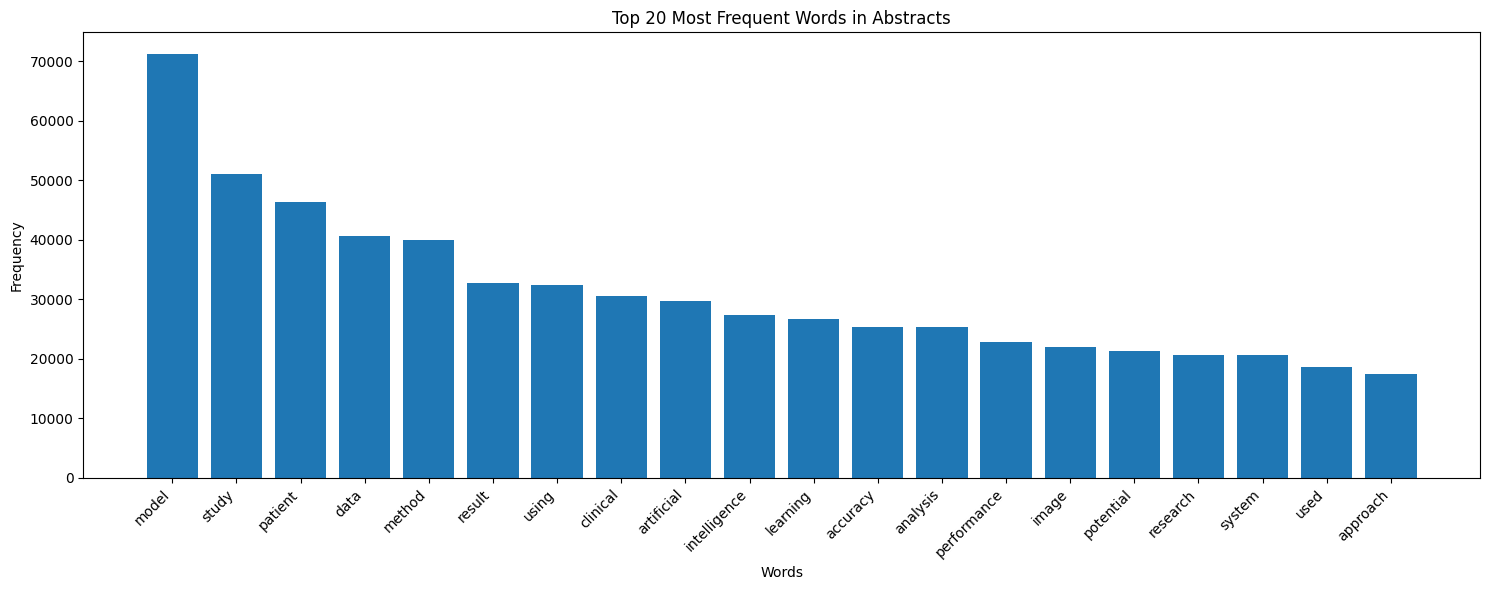

/home/willy/anaconda3/envs/topics_models/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


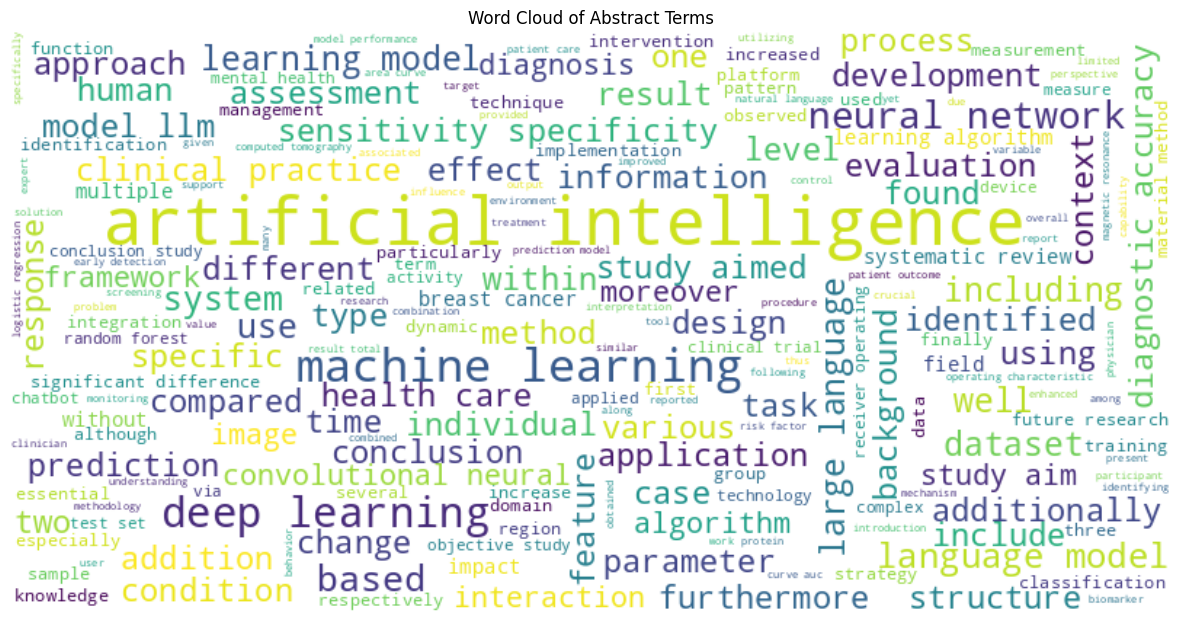


Total unique words: 127324

Top 20 most frequent words and their counts:
model: 71305
study: 51131
patient: 46342
data: 40599
method: 39894
result: 32757
using: 32429
clinical: 30484
artificial: 29779
intelligence: 27296
learning: 26748
accuracy: 25429
analysis: 25385
performance: 22760
image: 21956
potential: 21271
research: 20651
system: 20635
used: 18608
approach: 17502


In [17]:
# Create word frequency distribution
all_words = [word for doc in processed_docs for word in doc]
word_freq = Counter(all_words)

# Get the top 20 most common words
top_words = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20])

# Plot word frequencies
plt.figure(figsize=(15, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Frequent Words in Abstracts')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Create and display word cloud
text = ' '.join(all_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Abstract Terms')
plt.show()

print("\nTotal unique words:", len(word_freq))
print("\nTop 20 most frequent words and their counts:")
for word, count in top_words.items():
    print(f"{word}: {count}")


In [18]:
# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(processed_docs)

# Filter out extreme frequencies
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train LDA model
num_topics = 10  # You can adjust this number
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Print the topics
print("Top 10 words in each topic:")
for idx, topic in lda_model.print_topics(-1):
    print(f'\nTopic {idx + 1}:')
    print(topic)

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')


Top 10 words in each topic:

Topic 1:
0.027*"risk" + 0.023*"patient" + 0.017*"year" + 0.016*"age" + 0.014*"disease" + 0.013*"associated" + 0.011*"group" + 0.010*"factor" + 0.008*"analysis" + 0.008*"cohort"

Topic 2:
0.013*"control" + 0.009*"analysis" + 0.009*"brain" + 0.009*"change" + 0.008*"individual" + 0.008*"condition" + 0.008*"effect" + 0.007*"disorder" + 0.007*"cognitive" + 0.006*"using"

Topic 3:
0.019*"cell" + 0.019*"drug" + 0.014*"protein" + 0.012*"molecular" + 0.010*"gene" + 0.010*"disease" + 0.009*"therapeutic" + 0.009*"mechanism" + 0.008*"analysis" + 0.008*"discovery"

Topic 4:
0.028*"patient" + 0.018*"clinical" + 0.015*"using" + 0.013*"conclusion" + 0.010*"score" + 0.009*"accuracy" + 0.009*"included" + 0.008*"used" + 0.007*"test" + 0.007*"performance"

Topic 5:
0.015*"data" + 0.013*"review" + 0.013*"research" + 0.012*"application" + 0.011*"challenge" + 0.011*"potential" + 0.010*"clinical" + 0.010*"technology" + 0.009*"system" + 0.008*"development"

Topic 6:
0.023*"learning

In [19]:
# Prepare and visualize the LDA results using pyLDAvis
lda_visualization = pyLDAvis.gensim_models.prepare(
    lda_model, 
    corpus, 
    dictionary,
    sort_topics=False
)

# Save the visualization to an HTML file
pyLDAvis.save_html(lda_visualization, 'lda_visualization.html')

# Display the visualization in the notebook
pyLDAvis.display(lda_visualization)


In [ ]:
# Compute different coherence metrics
coherence_metrics = ['c_v', 'c_uci', 'c_npmi', 'u_mass']
coherence_scores = {}

print("Computing coherence scores using different metrics:\n")
for metric in coherence_metrics:
    try:
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=processed_docs,
            dictionary=dictionary,
            coherence=metric
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores[metric] = coherence_score
        print(f"{metric} coherence score: {coherence_score:.4f}")
    except Exception as e:
        print(f"Error computing {metric} coherence: {str(e)}")

# Create a bar plot of coherence scores
plt.figure(figsize=(10, 6))
plt.bar(coherence_scores.keys(), coherence_scores.values())
plt.title('Topic Coherence Scores by Metric')
plt.xlabel('Coherence Metric')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print explanation of the metrics
print("\nCoherence Metrics Explanation:")
print("- c_v: Based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity")
print("- c_uci: Based on a sliding window and pointwise mutual information (PMI)")
print("- c_npmi: Based on a sliding window and normalized pointwise mutual information (NPMI)")
print("- u_mass: Based on document co-occurrence counts and an intrinsic confirmation measure that uses conditional probability")
